# Gretel Navigator Tabular on AWS Bedrock

This Notebook will walk you through deploying Gretel Navigator Tabular as a Bedrock Marketplace Model. You can deploy Gretel Navigator as an endpoint in Bedrock and interact with the model using the Gretel SDK.

This Notebook will walk you through the following steps:

* Deploy Gretel Navigator Tabular on AWS Bedrock
* Install and configure the Gretel SDK
* Generate synthetic data with the Gretel SDK and the Bedrock Endpoint
* Edit and augment existing data with the Gretel SDK and the Bedrock Endpoint

# Deploy Gretel Navigator

To get started, visit the [AWS Bedrock homepage](https://us-west-2.console.aws.amazon.com/bedrock/home?region=us-west-2#/) in the AWS Console. In this example we'll be using `us-west-2`.

Under **Foundation Models**, select **Model Catalog**:

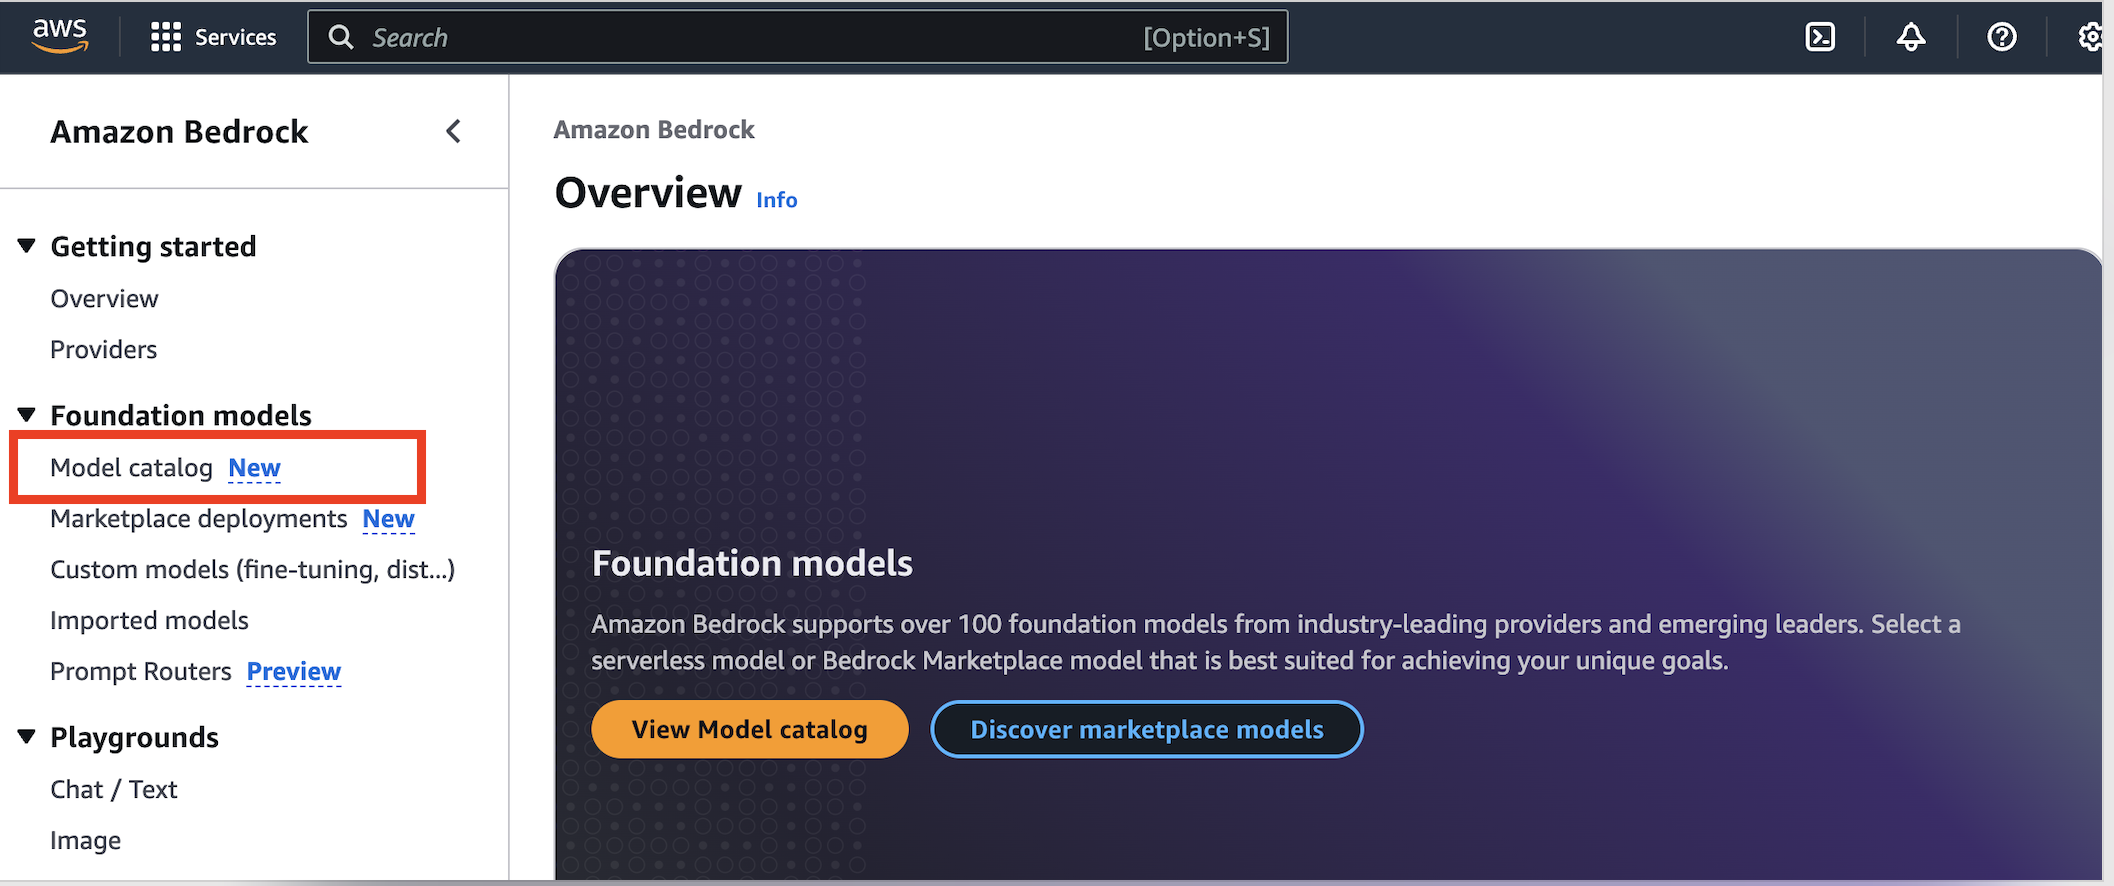

Under **Providers** on the left side, select **Gretel**:

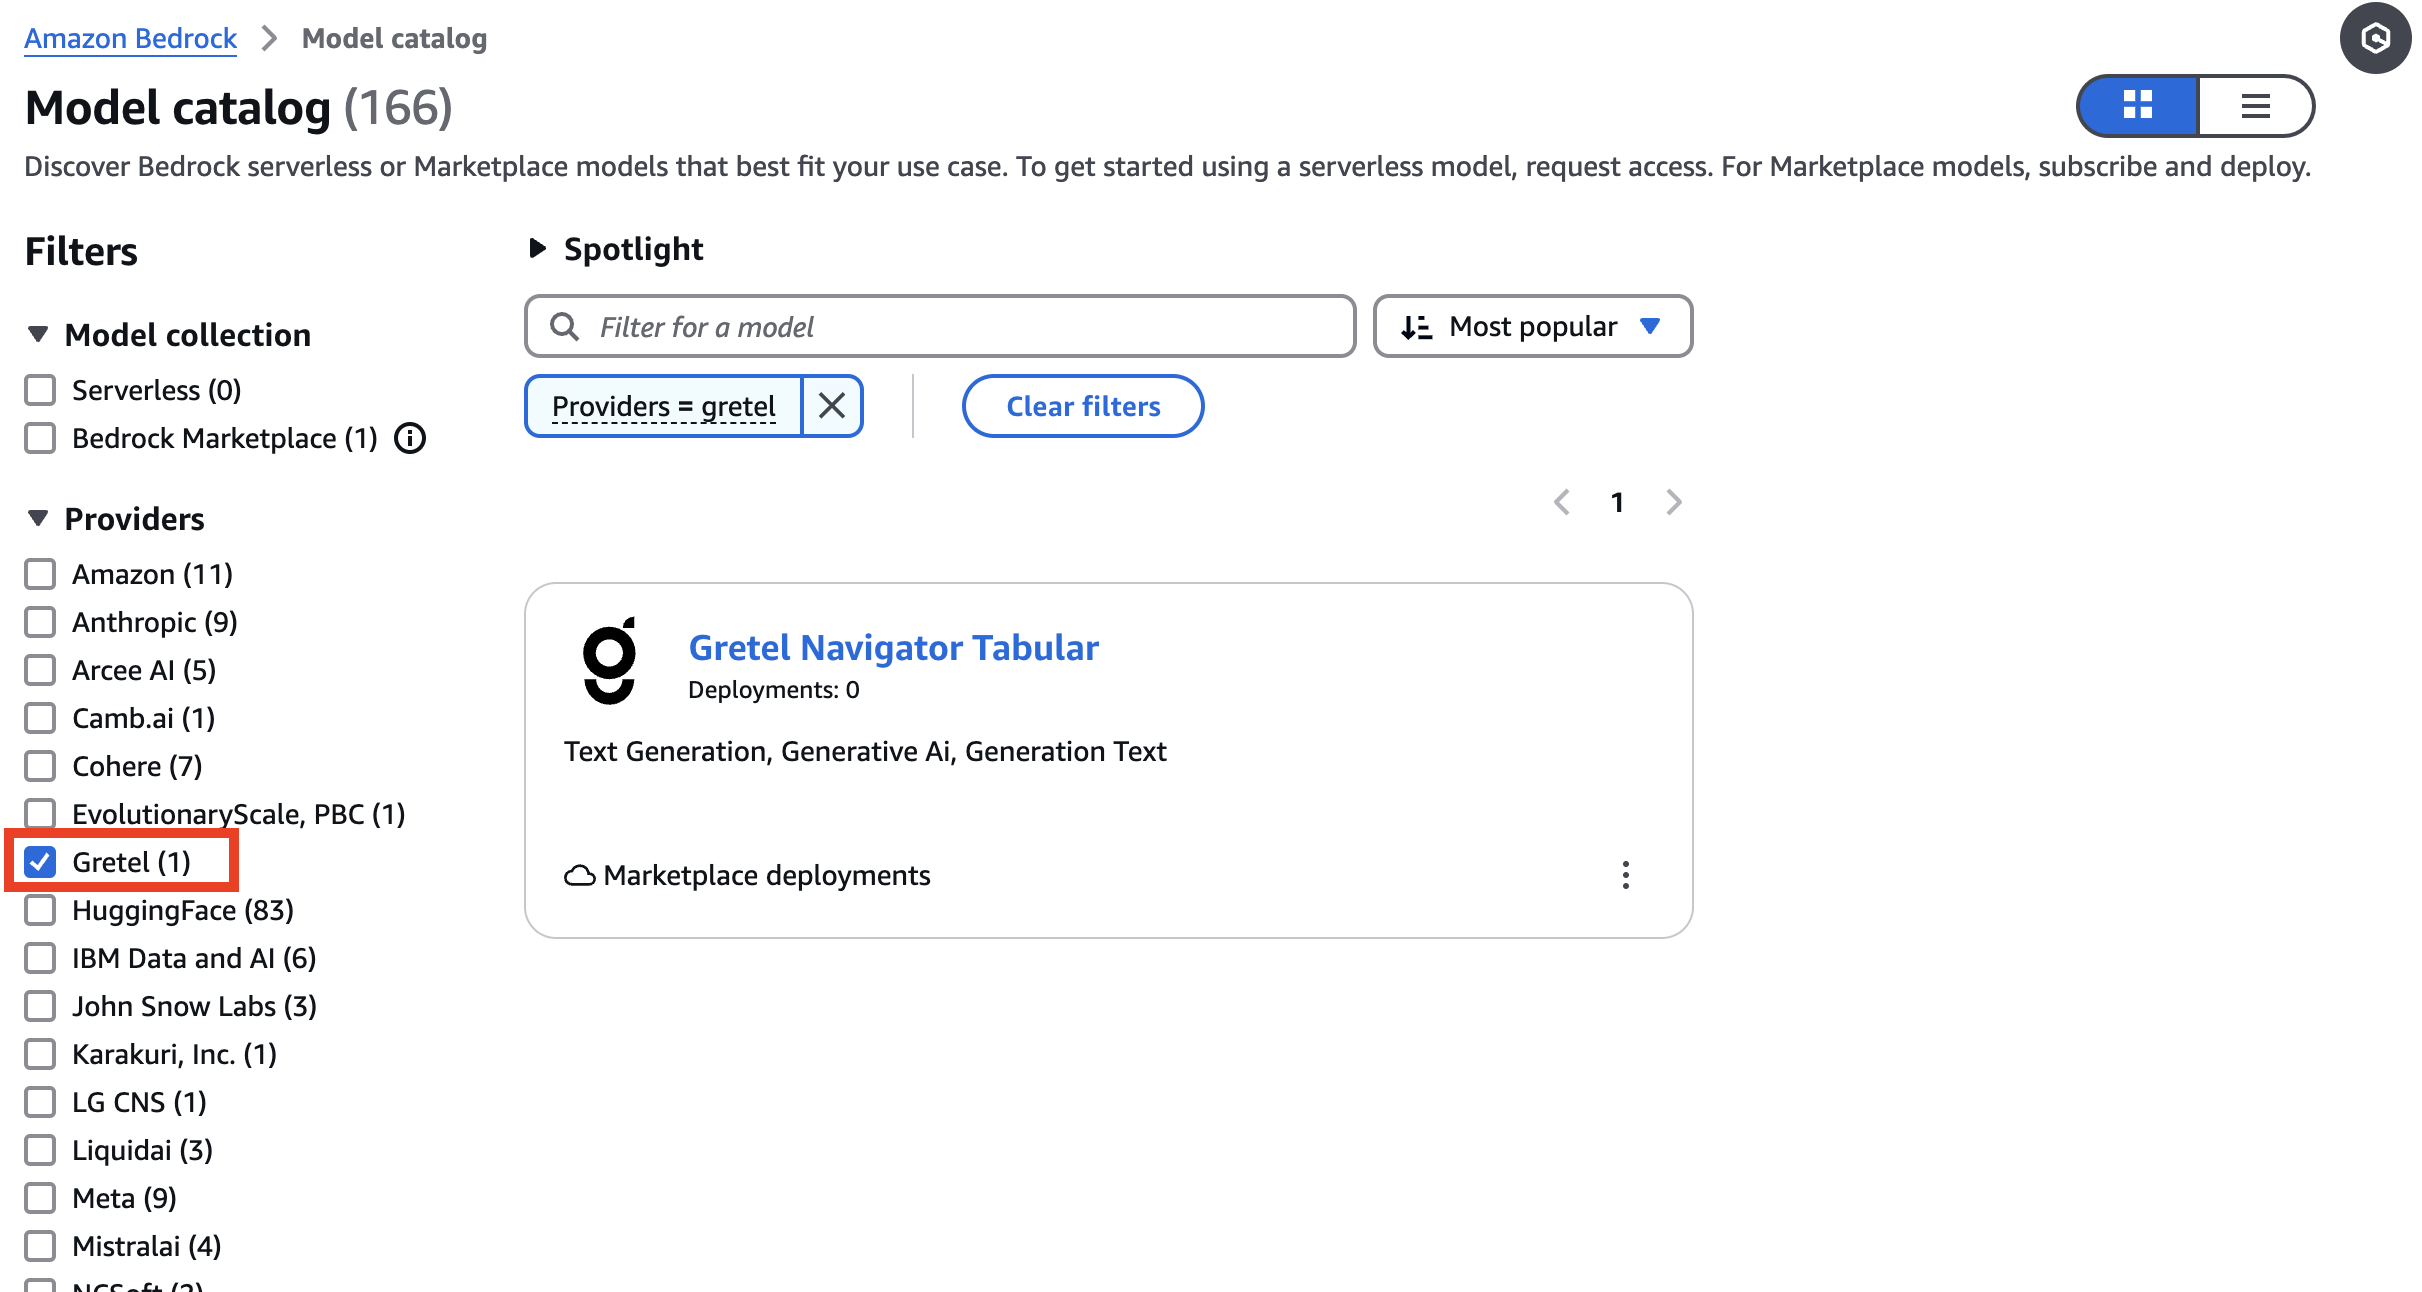

Click on **View subscription options**:

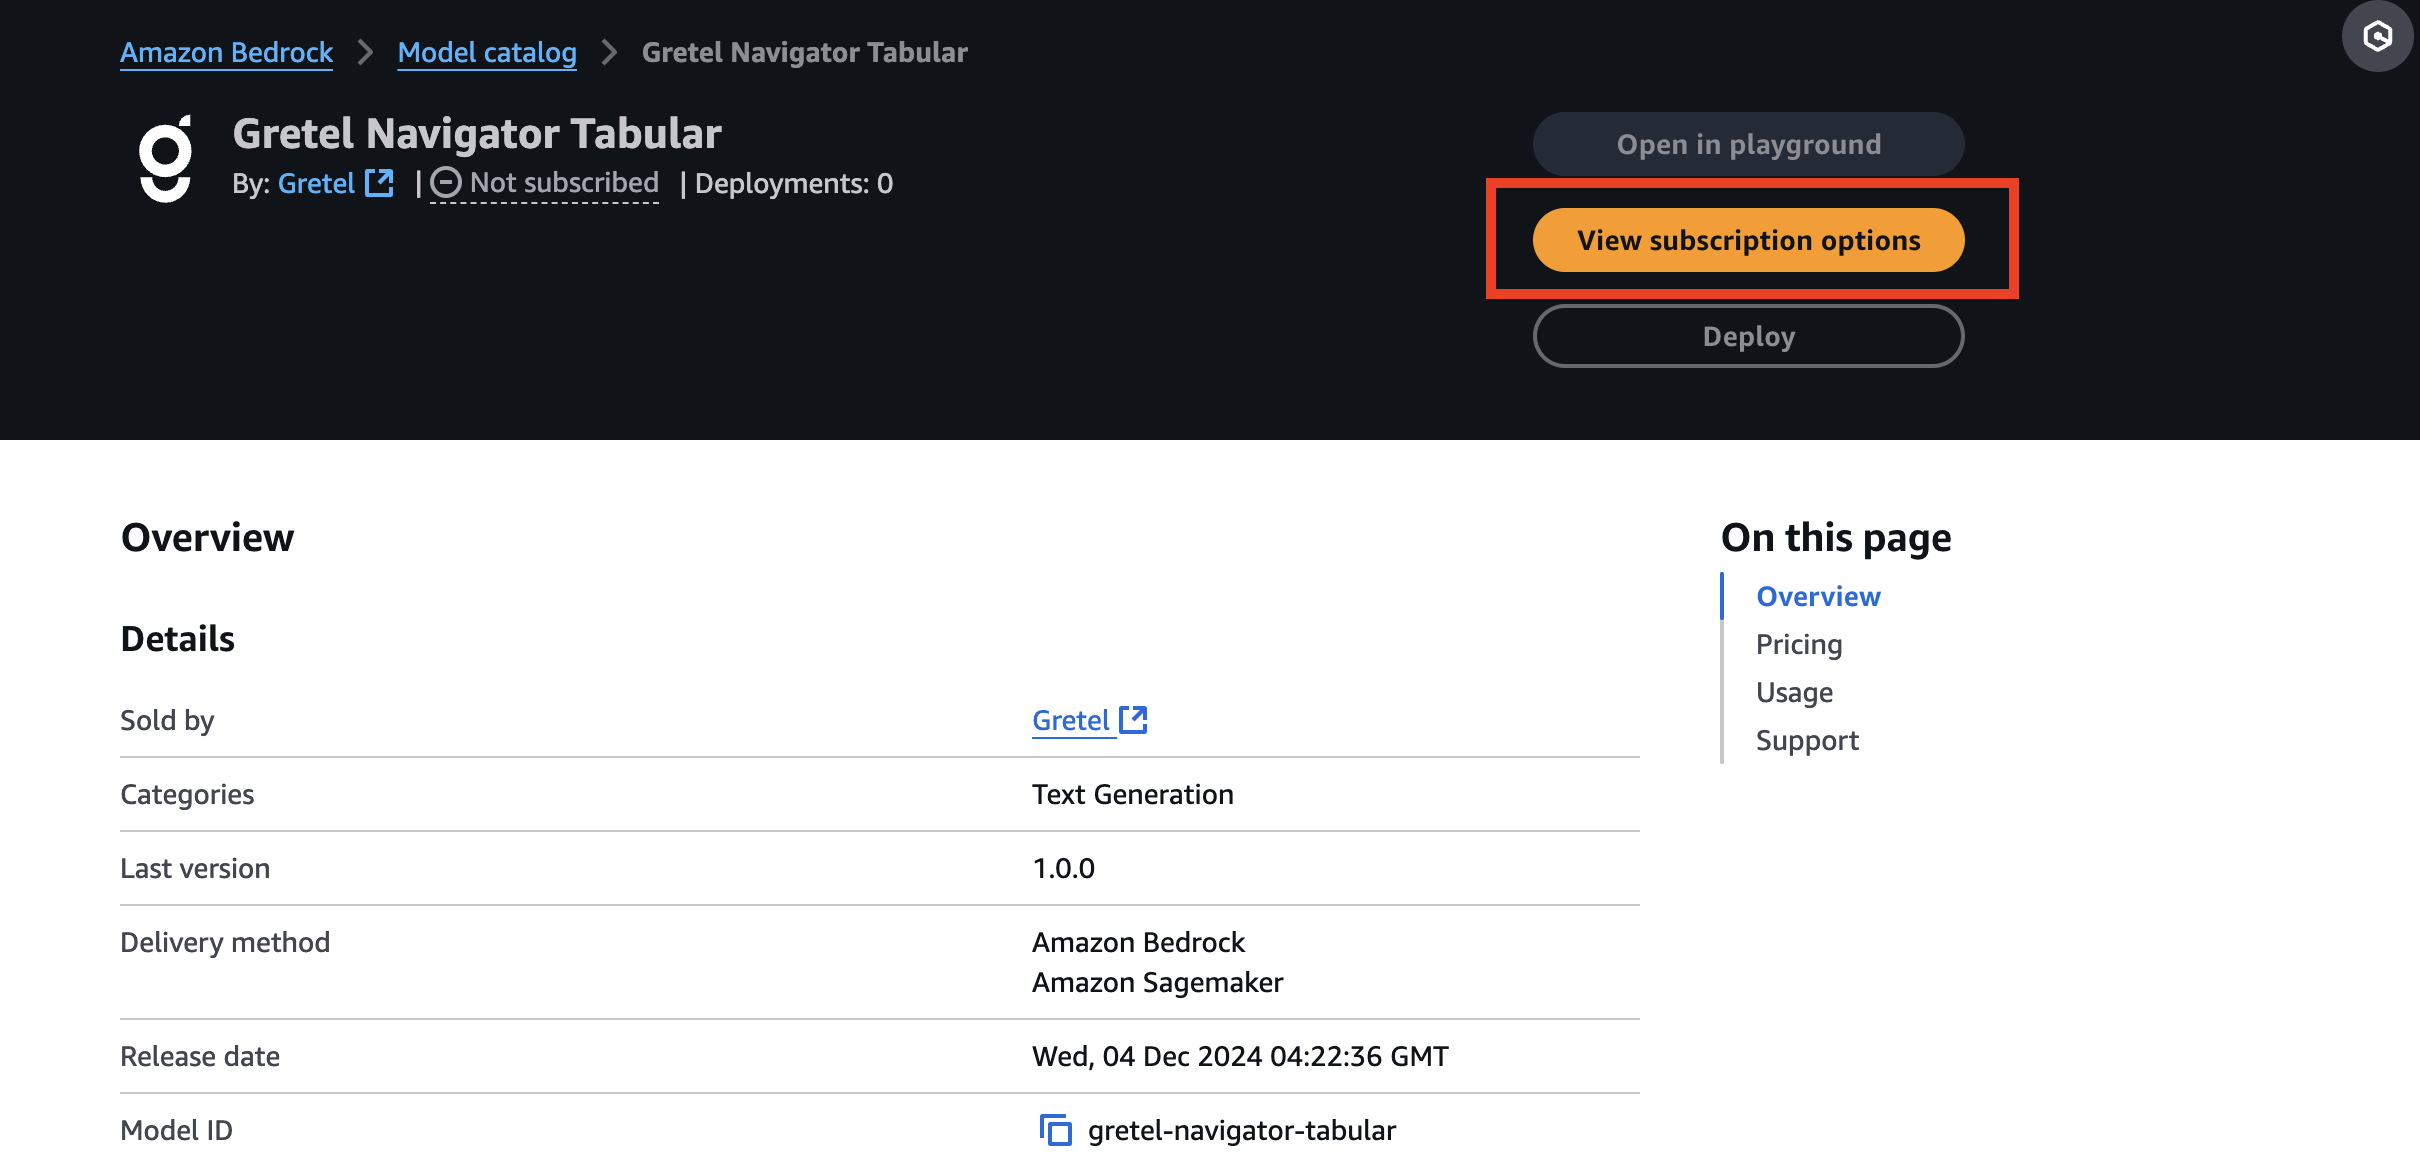

Click on **Subscribe**:

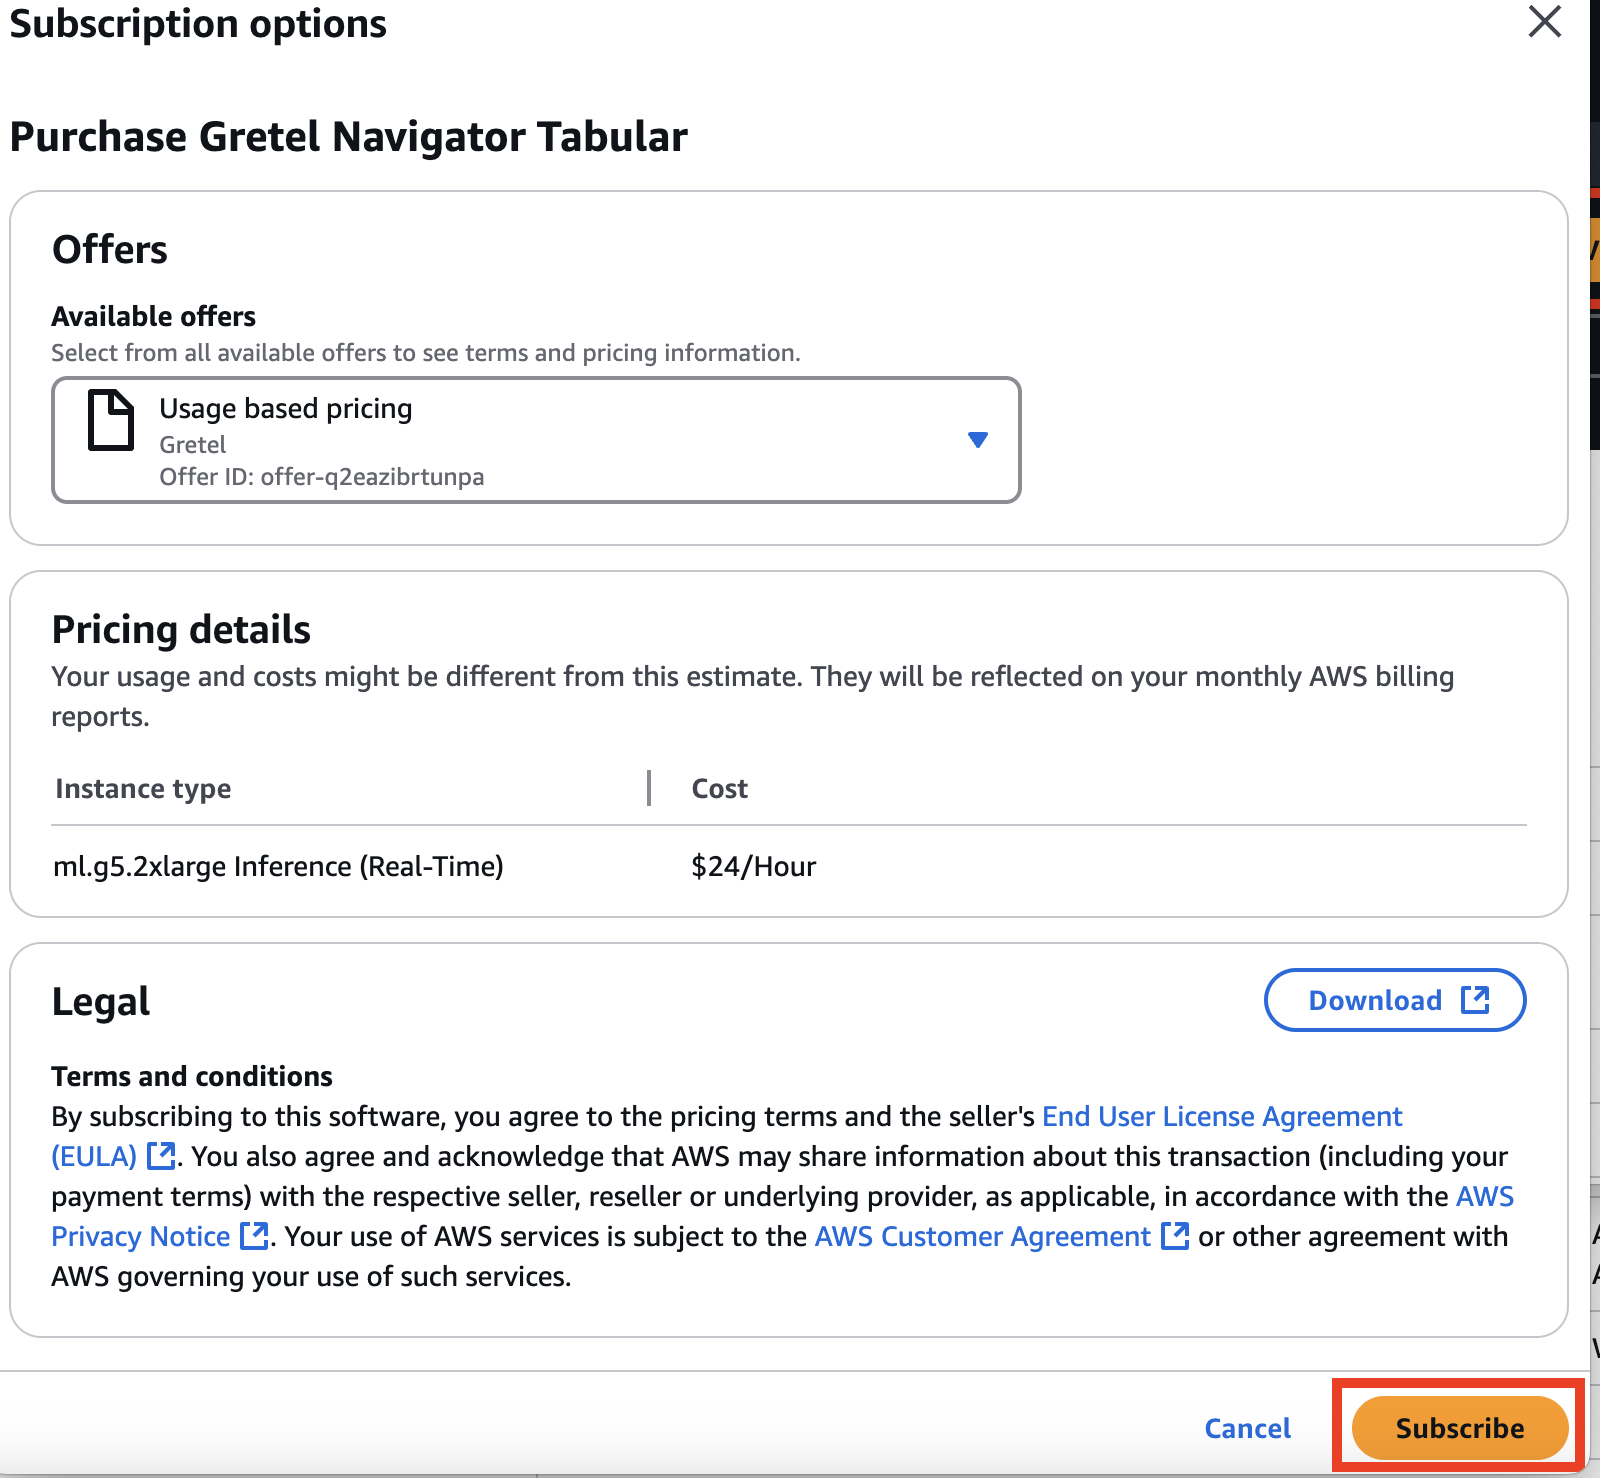

Wait for the subscription to complete:

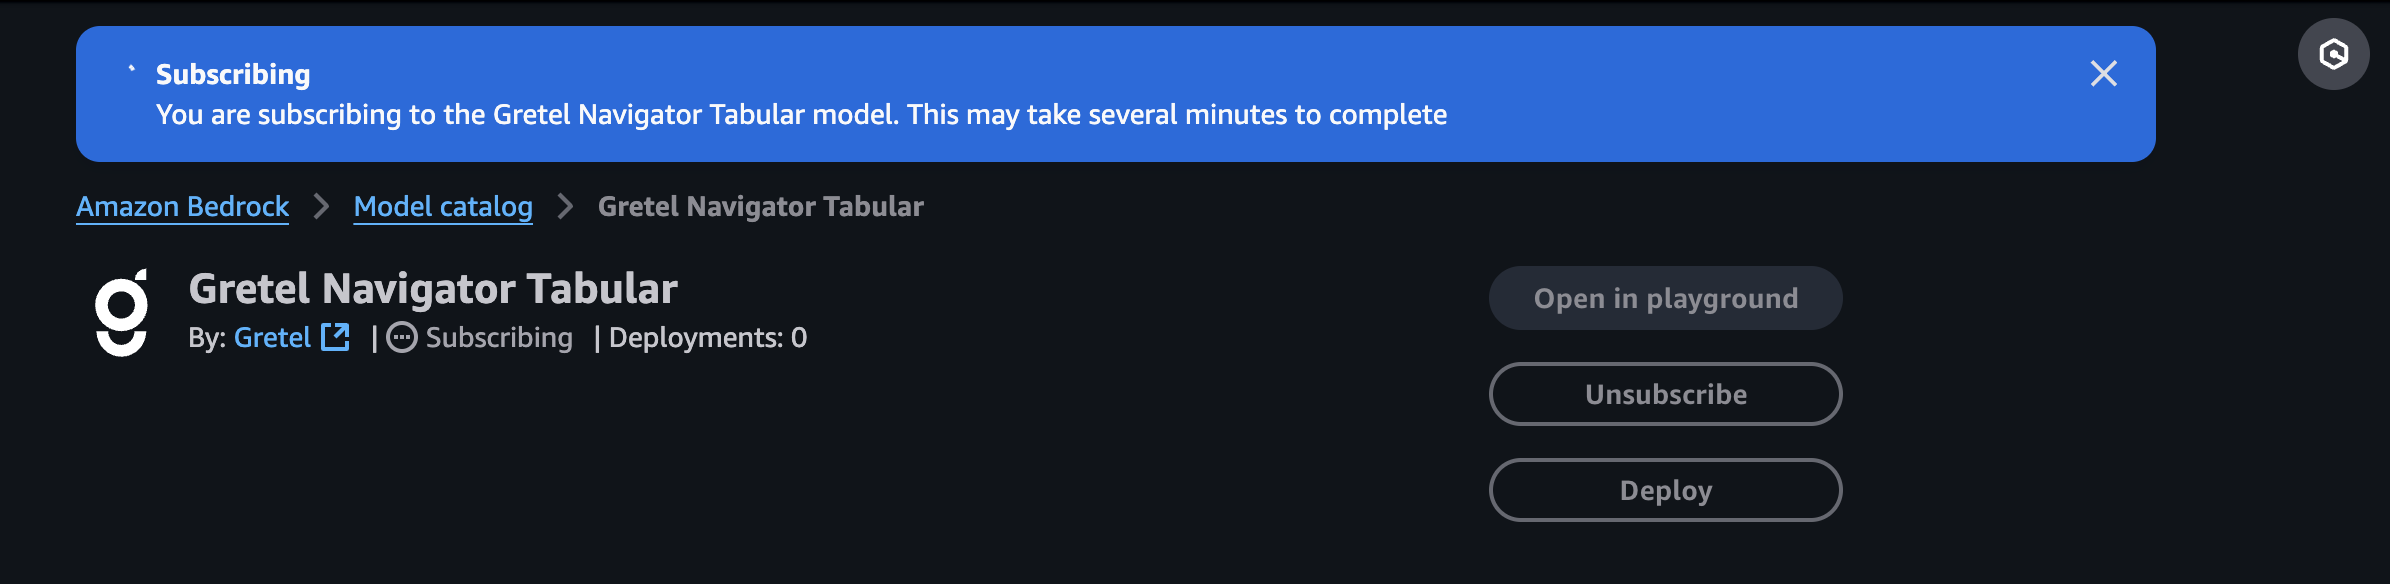

Once the subscription is complete, click **Deploy**:

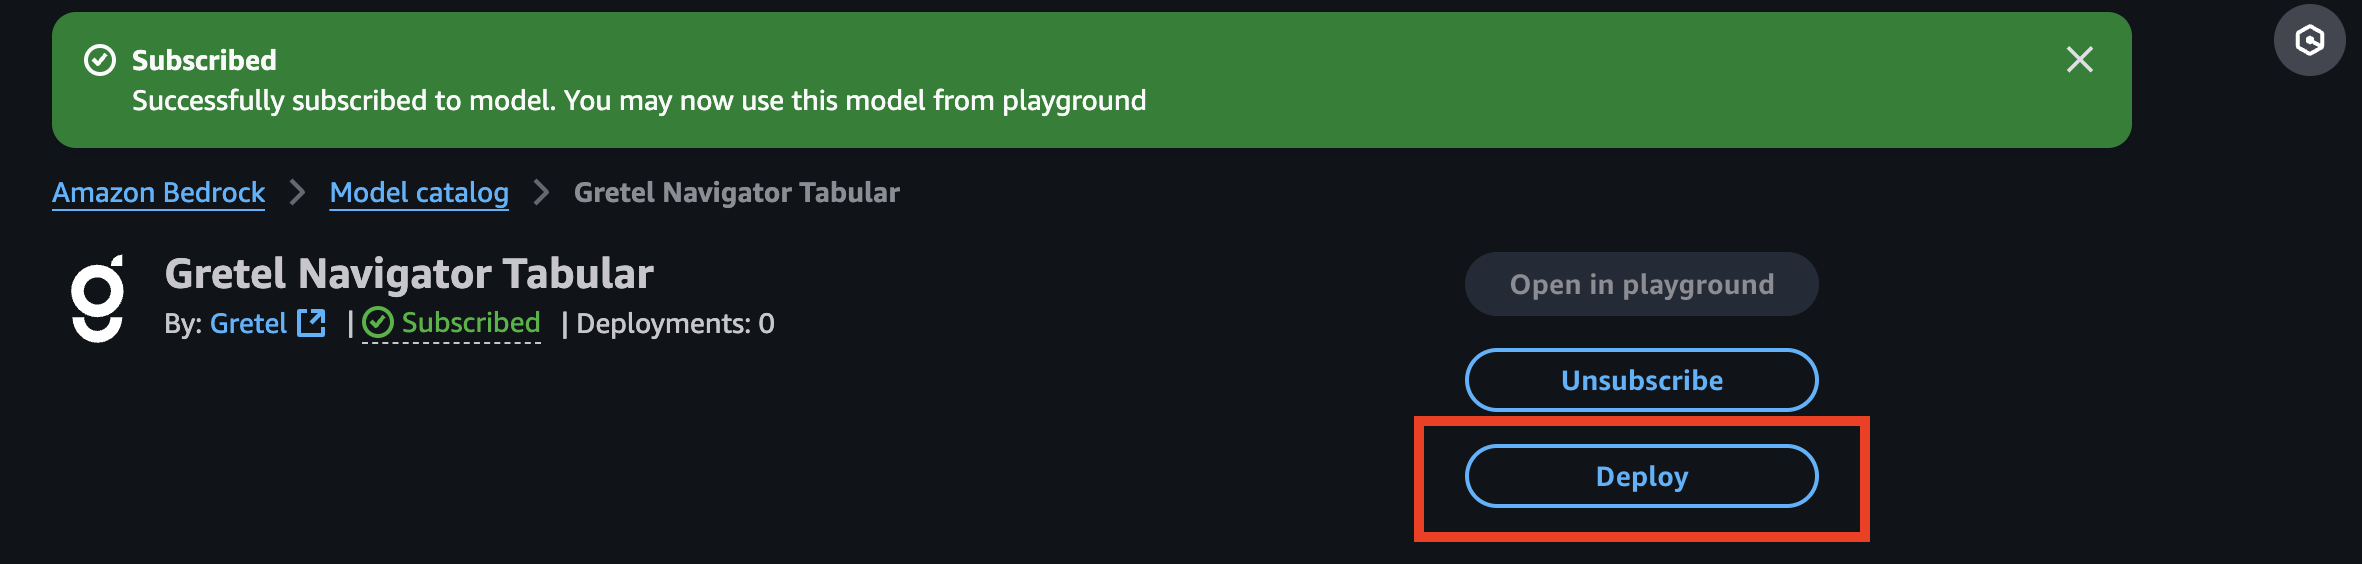

You should reach a configuration screen like below. For this example we will use the
defaults. Update the fields for your use case and modify the **Advanced Settings** as required.

When you are done with the configuration, click the **Deploy** button on the bottom right.

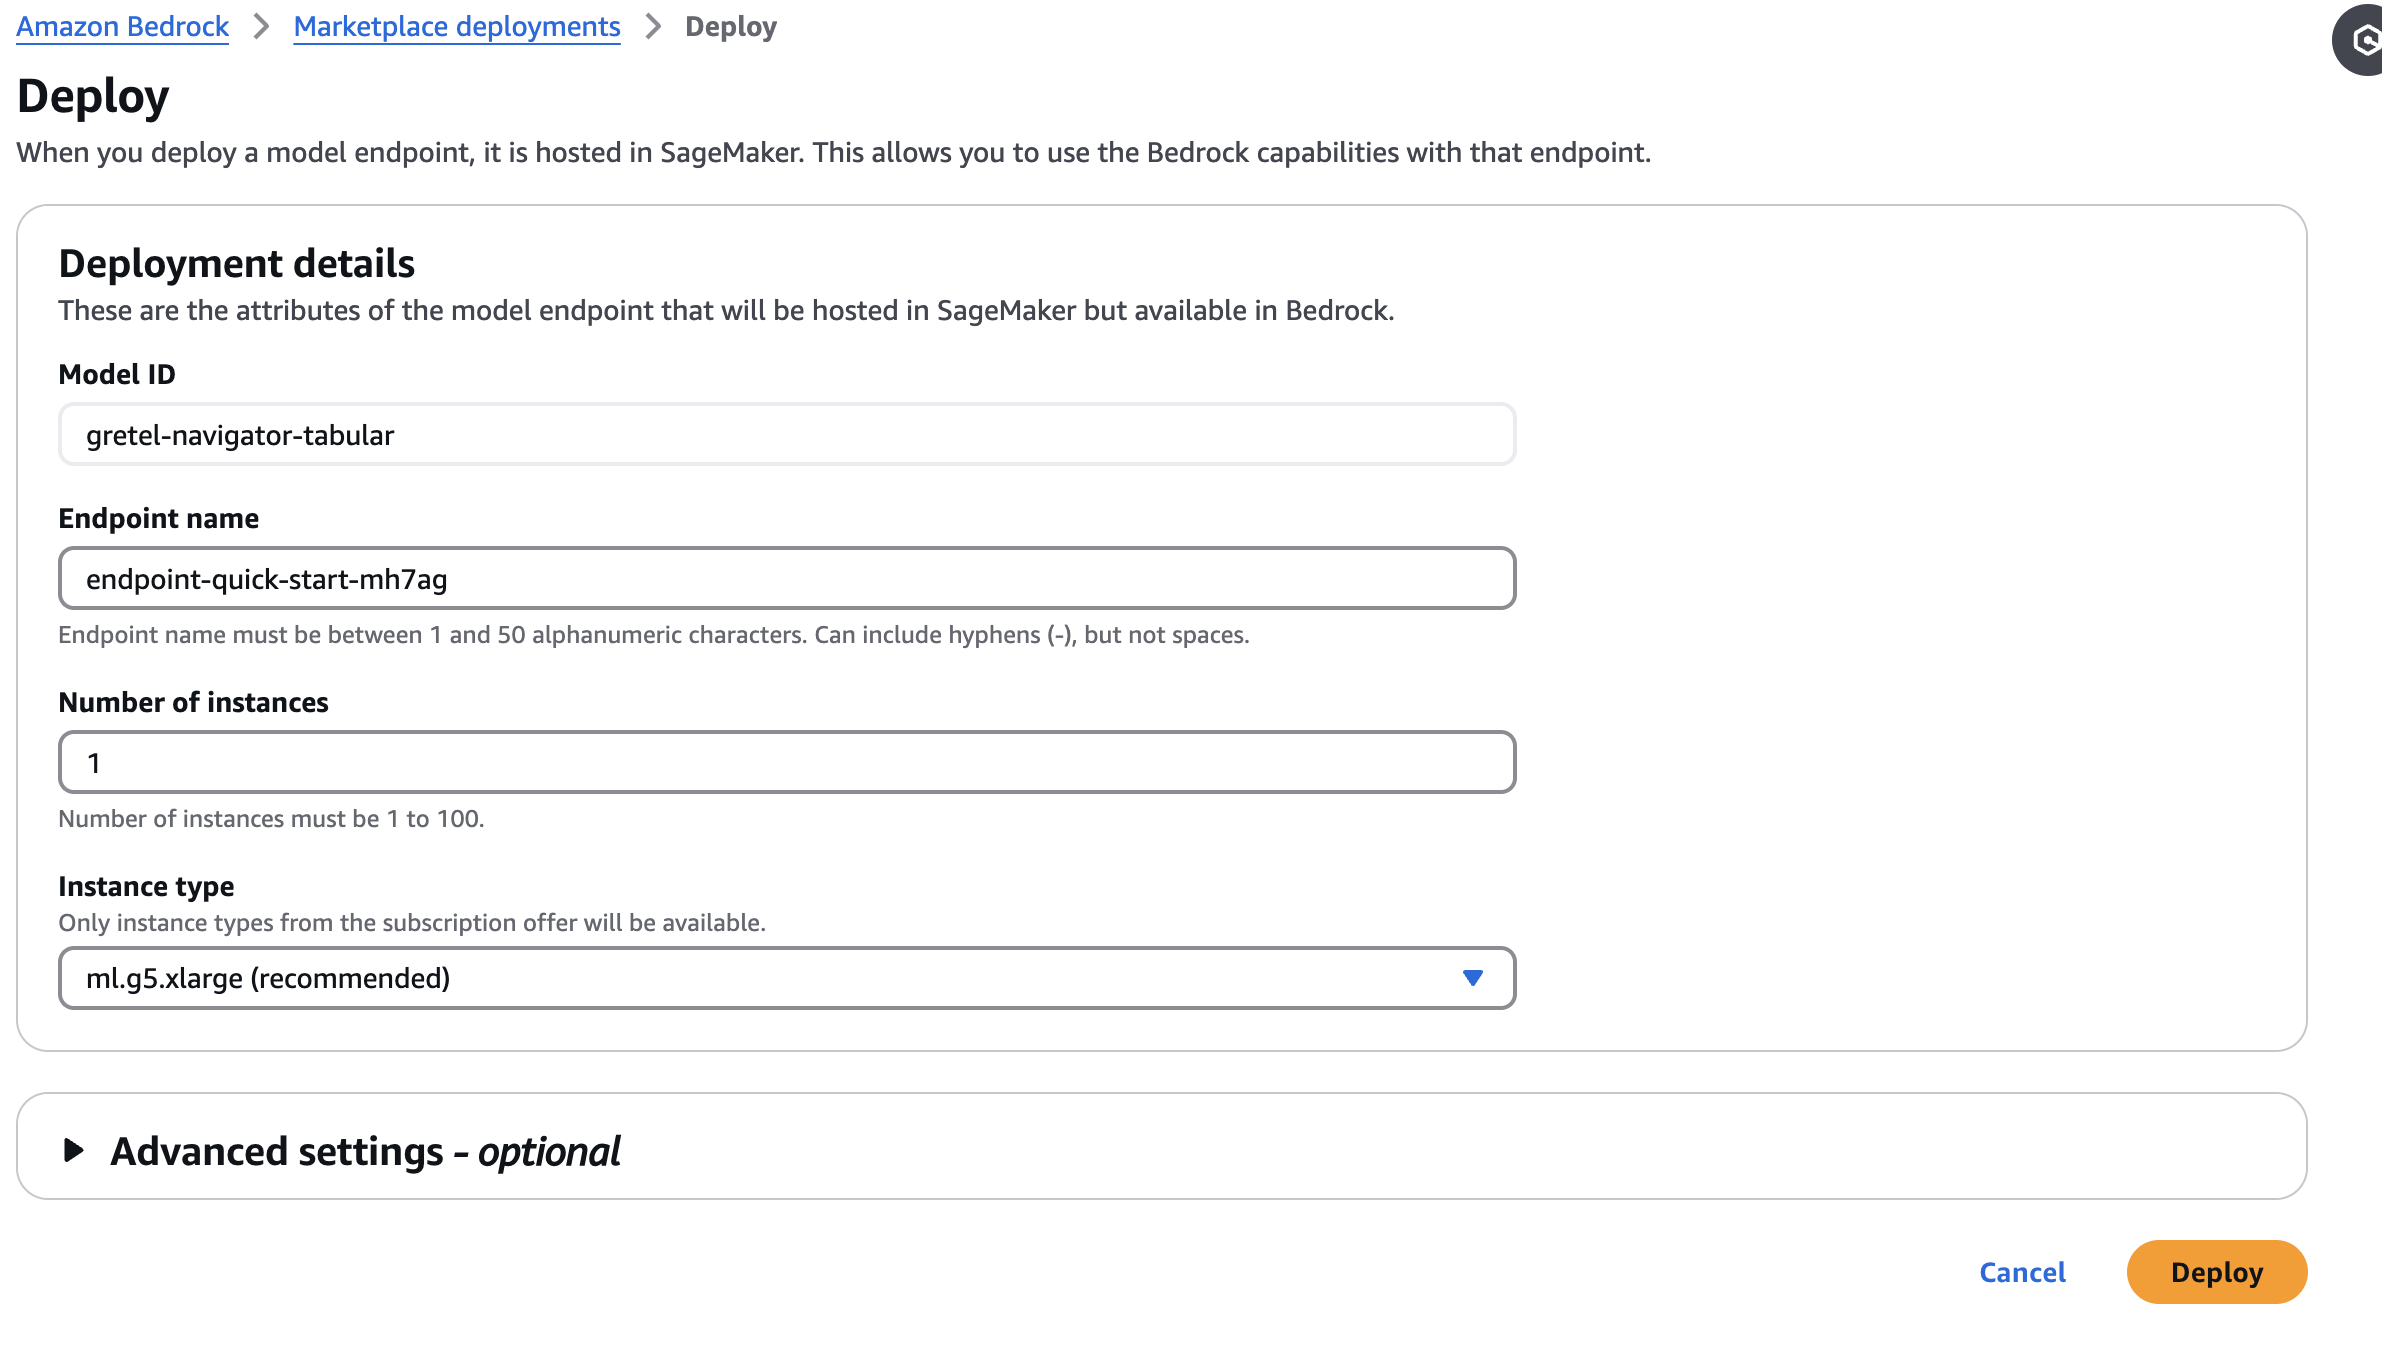


Remain on the page and you should eventually see something like this:

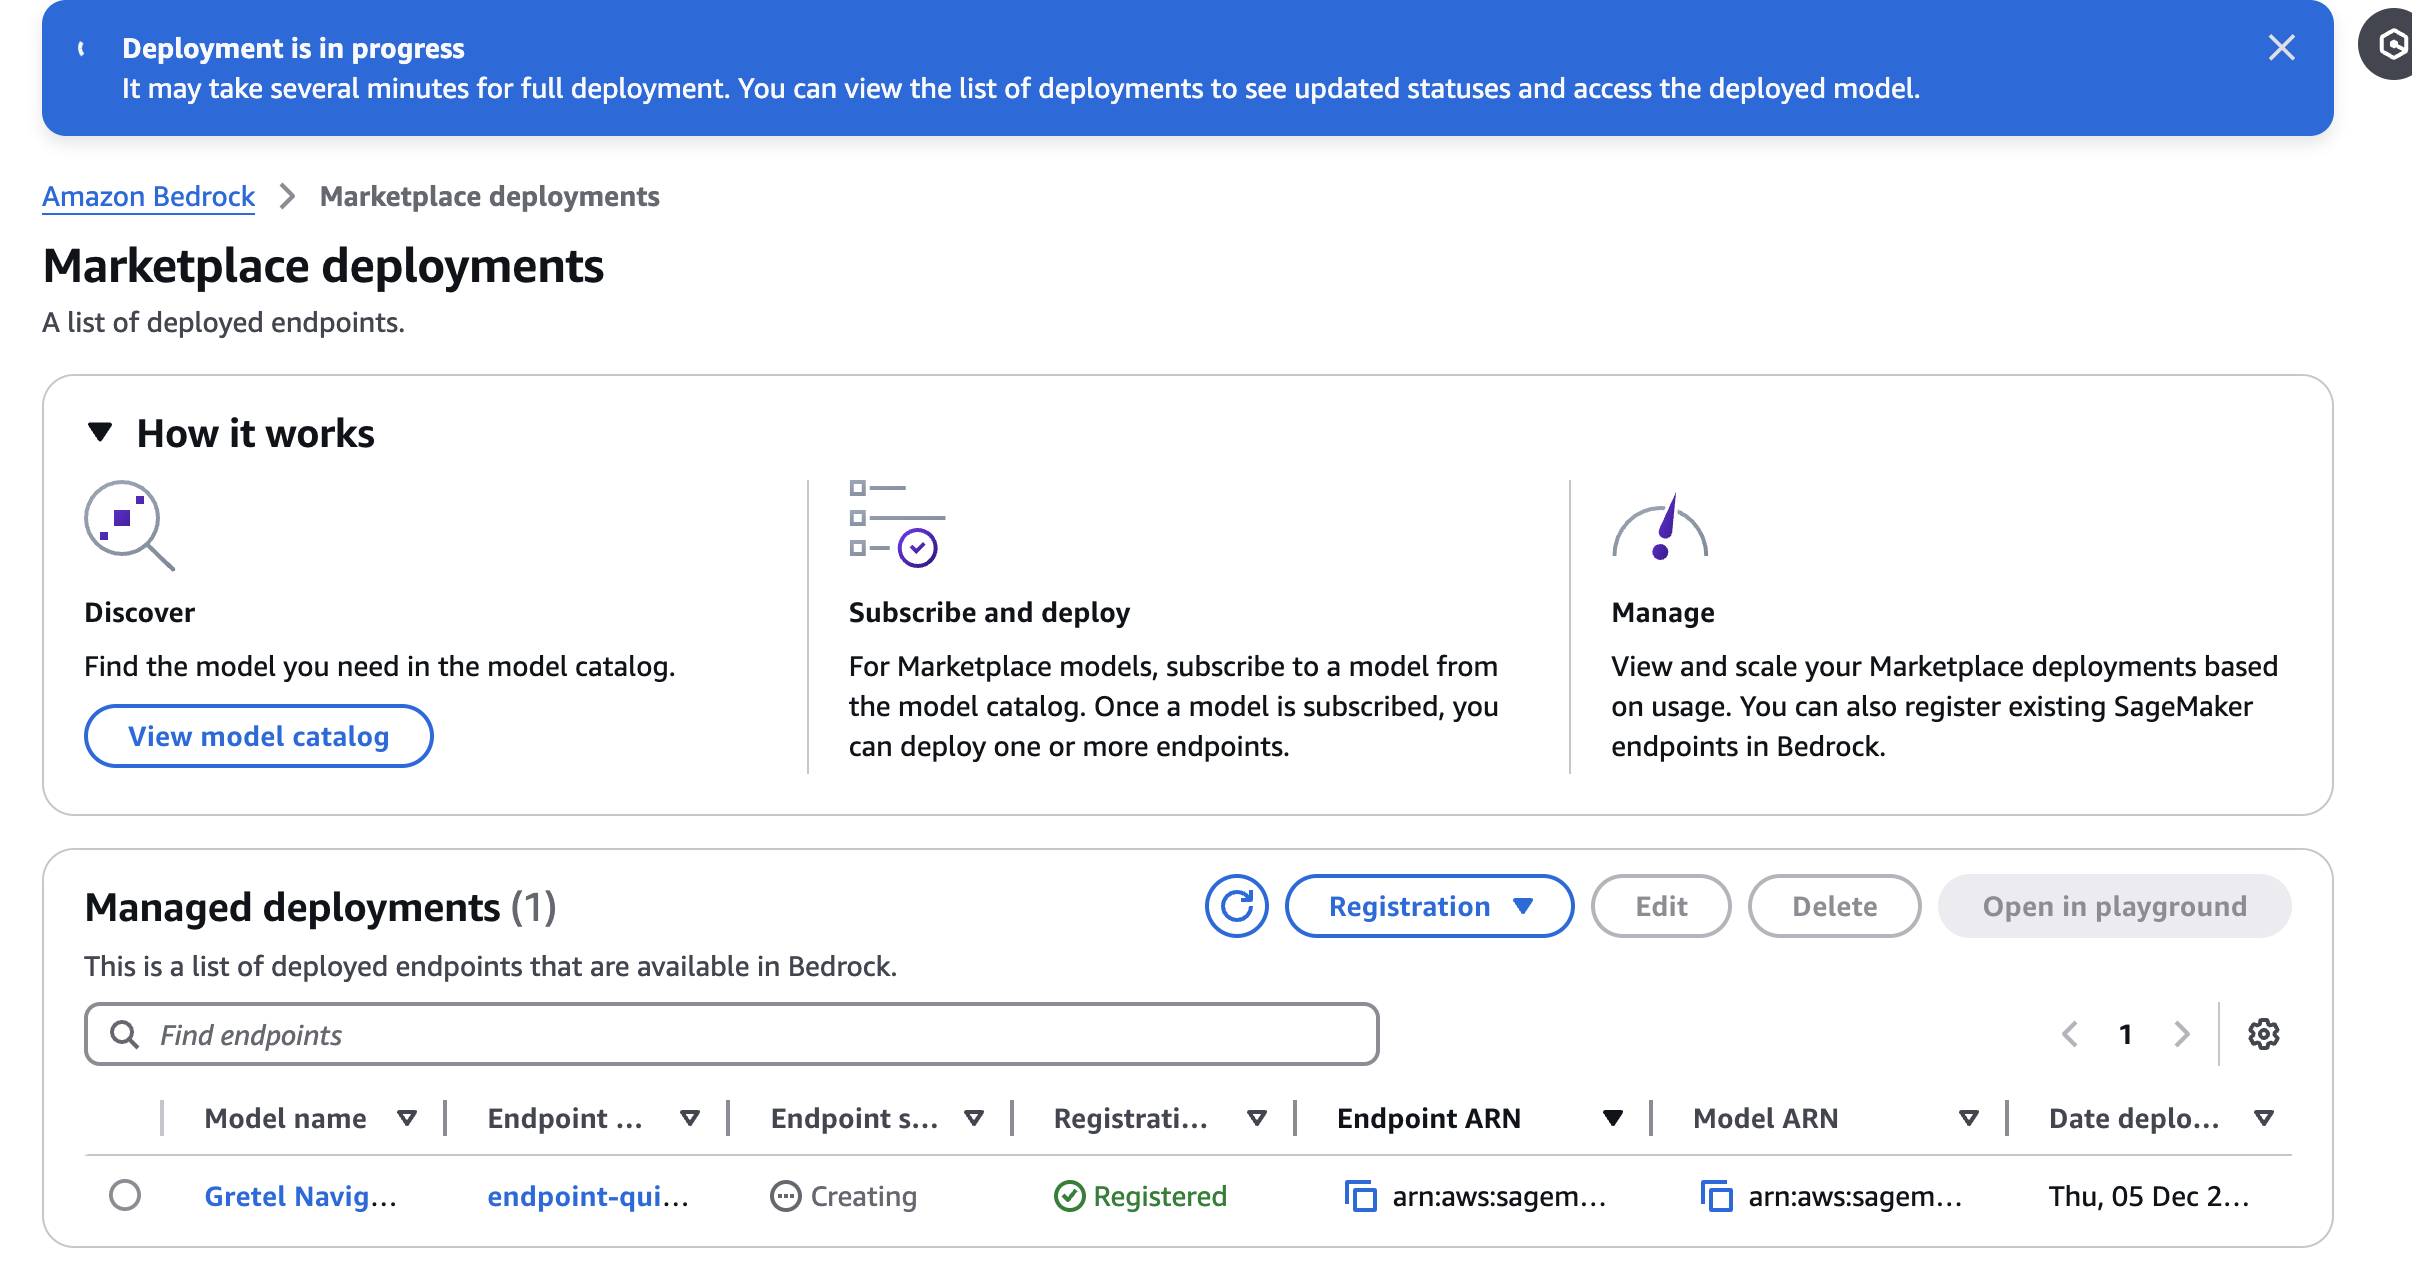

Wait for the model to deploy and the **Endpoint status** to change from **Creating** to **In Service**

From the **Marketplace deployments** page (see above). Retrieve the **Endpoint ARN** and set the variable below.

In [ ]:
# AWS Metadata - set these based on your deployment and AWS account

ENDPOINT_ARN = "arn:aws:sagemaker:us-west-2:101232344508:endpoint/endpoint-quick-start-mh7ag"

AWS_PROFILE = "john-sandbox.sandboxpoweruser"

AWS_REGION = "us-west-2"

In [ ]:
# Install the Gretel SDK and boto3 (if you do not already have it)

!pip install -U -qq "git+https://github.com/gretelai/gretel-python-client.git@main" boto3

In [ ]:
# Configure boto3 to use your AWS account that Gretel is deployed to

import boto3

boto3.setup_default_session(
        profile_name=AWS_PROFILE, region_name=AWS_REGION
)

bedrock_client = boto3.client("bedrock-runtime")

In [ ]:
# Create a Bedrock Adapter using the Gretel SDK

from gretel_client import Gretel

bedrock = Gretel.create_navigator_bedrock_adapter(bedrock_client, ENDPOINT_ARN)

In [ ]:
# First we'll generate some data from only a prompt. We provide a prompt and some existing sample data to guide the generation process.

import pandas as pd

PROMPT = """Generate a mock dataset for users from the Foo company based in France.
Each user should have the following columns:
* first_name: traditional French first names.
* last_name: traditional French surnames. 
* email: formatted as the first letter of their first name followed by their last name @foo.io (e.g., jdupont@foo.io)
* gender: Male/Female
* city: a city in France
* country: always 'France'.
"""

table_headers = ["first_name", "last_name", "email", "gender", "city", "country"]
table_data = [
    {
        "first_name": "Lea",
        "last_name": "Martin",
        "email": "lmartin@foo.io",
        "gender": "Female",
        "city": "Lyon",
        "country": "France",
    }
]

SAMPLE_DATA = pd.DataFrame(table_data, columns=table_headers)

metadata, synthetic_df = bedrock.generate(
    "gretelai/auto",
    PROMPT,
    num_records=10,
    sample_data=SAMPLE_DATA,
)

print(synthetic_df)
print("*******")
print(metadata)


In [ ]:
# Finally, we'll demonstrate Navigator's edititing mode, which can augment existing datasets. In this example we'll take our previously
# generated Synthetic DF and ask Navigator to augment it with new columns.

EDIT_PROMPT = """Edit the table and add the following columns:
* occupation: a random occupation
* education level: make it relevant to the occupation
"""

metadata, augmented_df = bedrock.edit(
    "gretelai/auto",
    EDIT_PROMPT,
    seed_data=synthetic_df
)

print(augmented_df)
print("*******")
print(metadata)